# Chapter 7: Modern Portfolio Theory
Constructing a portfolio involves solving a dual optimization problem that maximizes profit and minimizes risk. It is therefore a function of the weights assigned to the portfolio's securities, their average prices, their variance, and their correlation, under certain conditions expressed as inequalities, such as an upper bound on risk. Risk can be defined in many ways, the simplest being the variance of security prices. More generally, risk is defined through the investor's utility function, which takes into account both objectives and risk tolerance. Depending on the chosen conditions, the optimization problem to be solved can be classified as linear, quadratic, convex, or nonlinear. Generally, these problems cannot be solved in closed form and must therefore be solved numerically.

In [2]:
# Core numerical computing
import numpy as np
import pandas as pd
from typing import Dict, Tuple

# For financial data
import yfinance as yf       # Loading financial data
import empyrical as emp     # Performance metrics

# Book data (pip install "git+https://github.com/dppalomar/pob.git#subdirectory=python")
from pob_python import SP500_stocks_2015to2020, SP500_index_2015to2020

# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_theme(style="darkgrid")

# Optimization
import cvxpy as cp                  # interface for convex optimization solvers
from scipy.optimize import minimize, LinearConstraint   # for optimization
from scipy.linalg import cholesky
import warnings
warnings.filterwarnings('ignore')
print('NumPy version: {}'.format(np.__version__))
print('Pandas version: {}'.format(pd.__version__))
print('Seaborn version: {}'.format(sns.__version__))
print('YFinance version: {}'.format(yf.__version__))

NumPy version: 1.26.4
Pandas version: 2.2.2
Seaborn version: 0.13.2
YFinance version: 0.2.65


In [3]:
# Get data
stock_prices = SP500_stocks_2015to2020[["AAPL", "AMZN", "AMD", "GM", "GOOGL", "MGM", "MSFT", "QCOM", "TSCO", "UPS"]].loc["2019":]
T = stock_prices.shape[0]
T_trn = round(0.70*T)

stock_prices.head()

,AAPL,AMZN,AMD,GM,GOOGL,MGM,MSFT,QCOM,TSCO,UPS
Date,,,,,,,,,,
2019-01-02,38.629,1539.13,18.83,31.8934,1054.68,24.5435,98.8602,54.2052,80.3520,91.445
2019-01-03,34.781,1500.28,17.05,30.5755,1025.47,24.0660,95.2233,52.5998,78.8374,88.849
2019-01-04,36.266,1575.39,19.00,31.5995,1078.07,25.1086,99.6521,53.4497,80.4594,91.944
2019-01-07,36.185,1629.51,20.57,32.5760,1075.92,25.8296,99.7792,53.2986,81.6418,91.633
2019-01-08,36.875,1656.58,20.75,33.0026,1085.37,26.5116,100.5027,52.8359,81.5930,91.643


In [4]:
#
# Define portfolios
#
def EWP(X: pd.DataFrame) -> np.ndarray:
    N = X.shape[1]
    return np.repeat(1/N, N)

def design_MVP(mu: np.ndarray, Sigma: np.ndarray, lmd: float = 1) -> np.ndarray:
    N = len(Sigma)
    w = cp.Variable(N)
    prob = cp.Problem(cp.Maximize(mu @ w - (lmd/2) * cp.quad_form(w, Sigma)),
                      [cp.sum(w) == 1, w >= 0])
    prob.solve()
    return w.value

def MVP_lmd1(X_lin: pd.DataFrame) -> np.ndarray:
    X_log = np.log(1 + X_lin)
    mu = X_log.mean().values
    Sigma = X_log.cov().values
    return design_MVP(mu, Sigma, lmd=1)

def MVP_lmd4(X_lin: pd.DataFrame) -> np.ndarray:
    X_log = np.log(1 + X_lin)
    mu = X_log.mean().values
    Sigma = X_log.cov().values
    return design_MVP(mu, Sigma, lmd=4)

def MVP_lmd16(X_lin: pd.DataFrame) -> np.ndarray:
    X_log = np.log(1 + X_lin)
    mu = X_log.mean().values
    Sigma = X_log.cov().values
    return design_MVP(mu, Sigma, lmd=16)

def MVP_lmd64(X_lin: pd.DataFrame) -> np.ndarray:
    X_log = np.log(1 + X_lin)
    mu = X_log.mean().values
    Sigma = X_log.cov().values
    return design_MVP(mu, Sigma, lmd=64)

In [5]:
def backtest(
        portfolio_funcs: Dict[str, callable],
        prices: pd.DataFrame,
        lookback: int,
        rebalance_every: int = 1,
        cost_bps: float = 0
) -> Tuple[pd.DataFrame, Dict[str, pd.DataFrame]]:
    N = prices.shape[1]
    X = prices.pct_change().dropna()

    portf_rets = {}
    ws = {}

    for portfolio_name, portfolio_func in portfolio_funcs.items():
        print(f"Backtesting portfolio {portfolio_name}...")

        # Initialize variables
        current_w = np.repeat(0, N)
        w = pd.DataFrame(index=X.index, columns=X.columns)
        portf_ret = pd.Series(index=X.index)
        portf_ret.name = portfolio_name

        for t in range(lookback, len(X)):
            # Rebalance portfolio if necessary
            if (t - lookback) % rebalance_every == 0:
                new_w = portfolio_func(X.iloc[t-lookback:t])  # Note that the row at time t is not included
                turnover = np.abs(new_w - current_w).sum()
                transaction_cost = turnover * cost_bps / 1e4
                current_w = new_w

            # Store weights
            w.iloc[t] = current_w

            # Calculate portfolio return for this period
            period_return = (X.iloc[t] * current_w).sum()
            portf_ret.iloc[t] = period_return - transaction_cost

            # Update normalized weights based on asset performance
            current_w = current_w * (1 + X.iloc[t])
            current_w = current_w / current_w.sum()

        # Keep a record (remove inital NaNs)
        portf_rets[portfolio_name] = portf_ret[lookback:]
        ws[portfolio_name] = w[lookback:]

    # Combine all portfolio returns into a single DataFrame
    portf_rets_df = pd.DataFrame(portf_rets)

    return portf_rets_df, ws

In [6]:
def plot_initial_allocations(bt_w: Dict[str, pd.DataFrame]) -> None:
    # Extract the first row of each portfolio's weights and prepare for plotting
    first_rows = {
        portfolio_name: weights.iloc[0]  # Get the first row of each DataFrame
        for portfolio_name, weights in bt_w.items()
    }

    # Convert the dictionary of first rows into a DataFrame
    first_rows_df = pd.DataFrame(first_rows).T.reset_index()  # Transpose and reset index
    first_rows_df.columns = ['portfolio'] + list(first_rows_df.columns[1:])

    # Barplot of weight allocation
    melted_df = first_rows_df.melt(id_vars='portfolio', var_name='stocks', value_name='weights')

    fig, ax = plt.subplots(figsize=(12, 4))
    sns.barplot(x='stocks', y='weights', hue='portfolio', ax=ax, data=melted_df)
    ax.set_title("Weight Allocation for Heuristic Portfolios")
    plt.xticks(rotation=45)
    plt.show()

In [7]:
# Run backtest
bt_ret, bt_w = backtest(
    {
        "1/N": EWP,
        "MVP (lmd = 1)": MVP_lmd1,
        "MVP (lmd = 4)": MVP_lmd4,
        "MVP (lmd = 16)": MVP_lmd16,
        "MVP (lmd = 64)": MVP_lmd64,
    },
    stock_prices, lookback=T_trn, rebalance_every=30)

Backtesting portfolio 1/N...
Backtesting portfolio MVP (lmd = 1)...
Backtesting portfolio MVP (lmd = 4)...
Backtesting portfolio MVP (lmd = 16)...
Backtesting portfolio MVP (lmd = 64)...


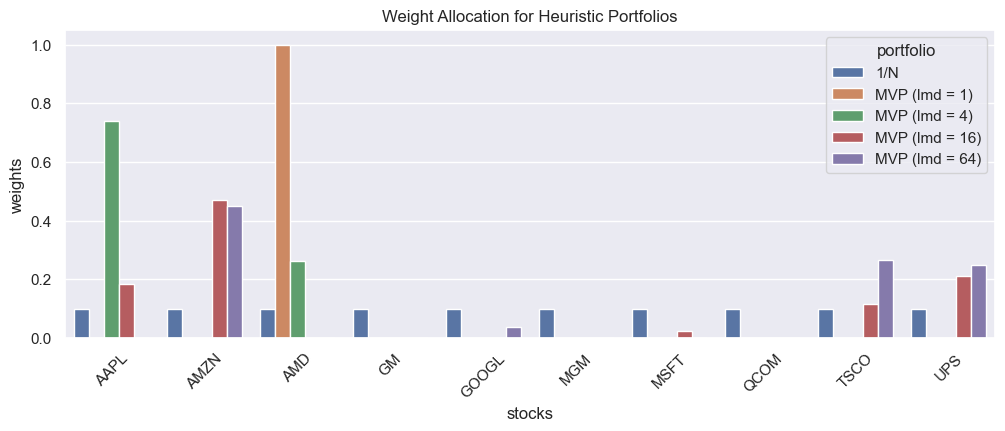

In [8]:
plot_initial_allocations(bt_w)